# <center>ResNet50 MODEL WITH AUGMENTED DATA - LIMITED TYPES - LABELING CORRECTIONS</center>
***
In this notebook, we will use back the previous ResNet model with Data Augmentation and we will group some types together.<br>
The labels of passports and ID documents have been corrected before processing.<br>

The new type will be 'text'. Consequently, will remain the following types:<br>
* 'id_pieces', 'passeport', 'paye', 'carte postale', 'advertisement', 'handwritten', 'text'.<br>

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. CONSTANTS<br>
> C. COLLECTING DATA<br>
> D. GROUPING SOME TYPES<br>
> E. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> F. PREPARATION OF DATA WITH PREPROCESSING AND DATA AUGMENTATION<br>

## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE<br>
> B. EARLY STOPPING<br>

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF ResNet50 PRE-TRAINED MODEL<br>
> B. MODEL CREATION WITH LAST LAYERS<br>
> C. COMPILING AND TRAINING<br>
> D. TRAINING HISTORY<br>
> E. CONFUSION MATRIX<br>
> F. CLASSIFICATION REPORT<br>

## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF TOP LAYERS OF ResNet50<br>
> B. COMPILING AND TRAINING<br>
> C. TRAINING HISTORY<br>
> D. CONFUSION MATRIX<br>
> E. CLASSIFICATION REPORT<br>

## <font color = blue>V. WRONG PREDICTIONS</font>

## <font color = blue>VI. SAVING PREDICTIONS</font>
***
##### Additional information before to get started :
* Recommended resolution for the pre-trained ResNet model : (224, 224, 3).
    * https://keras.io/api/applications/resnet/
* resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

##### Laptop specification :
* OS: Windows 11
* Processor: AMD Ryzen 7 5800HS with Radeon Graphics 3.20 GHz
* Installed RAM: 16,0 GB
* GPU: NVIDIA GetForce RTX3080 8GB
***

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from helpers import load_image, show_wrong_predictions, confusion_matrix, global_classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers

> B. CONSTANTS

In [2]:
BATCH_SIZE       = 16                # Bacth size for dataset
TARGET_SIZE      = (224, 224)        # Resolution of images before training
INPUT_SHAPE      = (224, 224, 3)     # Resolution of images with channels before training
IMAGES_DIRECTORY = '../data/final/'  # Directory where are located images

SAVED_WEIGHTS    = './model/model_ResNet50_AugmentedData_FewTypes_corr.h5'  # File name where are saved the final weights of the model

> C. COLLECTING DATA

In [3]:
df = pd.read_csv('../data/data_with_meta_corr.csv')   # Data with labeling corrections
df.head()

filename                                                url  \
0  img_0000000.jpg  https://templates.invoicehome.com/modele-factu...   
1  img_0000001.jpg  https://templates.invoicehome.com/modele-factu...   
2  img_0000002.jpg  https://www.coover.fr/wp-content/uploads/2021/...   
3  img_0000003.jpg  https://templates.invoicehome.com/modele-factu...   
4  img_0000004.jpg  https://files.intum.com/v/vosfactures/files/31...   

                                         description     type  \
0  100 modèles gratuits de factures | Téléchargem...  facture   
1  100 modèles gratuits de factures | Téléchargem...  facture   
2  Facture proforma : modèle à télécharger gratui...  facture   
3  100 modèles gratuits de factures | Téléchargem...  facture   
4  Base de Connaissances - Vos Factures - Créer u...  facture   

                  filepath  scraped     old_filename  \
0  ./final/img_0000000.jpg        1  img_0000000.jpg   
1  ./final/img_0000001.jpg        1  img_0000001.jpg   
2  ./final/img_0000002.jpg        1  img_0000002.jpg   
3  ./final/img_0000003.jpg        1  img_0000003.jpg   
4  ./final/img_0000004.jpg        1  img_0000004.jpg   

                old_filepath  height  width  channels  landscape  
0  ./facture/img_0000000.jpg  1061.0  750.0       3.0        0.0  
1  ./facture/img_0000001.jpg  1061.0  750.0       3.0        0.0  
2  ./facture/img_0000002.jpg  1024.0  726.0       3.0        0.0  
3  ./facture/img_0000003.jpg  1061.0  750.0       3.0        0.0  
4  ./facture/img_0000004.jpg   771.0  773.0       3.0        1.0

> D. GROUPING SOME TYPES

In [4]:
# Listing of all types
types_all = df.type.unique()

In [5]:
# Listing of types that we keep
type_keep = ['id_pieces', 'passeport', 'paye', 'carte postale', 'advertisement', 'handwritten']

# Replacement of other types by 'text'
for typ in types_all:
    if typ not in type_keep:
        df['type'] = df['type'].replace(typ, 'text')
        
# Calculation of the number of remaining types
NUMBER_OF_TYPES = len(df.type.unique())

> E. SPLIT BETWEEN TRAINING SET AND TEST SET

In [6]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df.filename, df.type,
                                                              test_size = 0.2, random_state = 1234)

data_train ={'filename': X_train_path, 'type': y_train.astype('category')}
df_train = pd.DataFrame(data_train)

data_test ={'filename': X_test_path, 'type': y_test.astype('category')}
df_test = pd.DataFrame(data_test)

> F. PREPARATION OF DATA WITH PREPROCESSING

In [7]:
# Images generator for training set (Base without Augmented Data)
train_data_generator_Base = ImageDataGenerator(preprocessing_function = preprocess_input)          # data preprocessing

# Images generator for training set (Augmented Data)
train_data_generator_AD = ImageDataGenerator(rotation_range = 90,       # Degree range for random rotations
                                             width_shift_range = 0.05,  # Fraction of total width, if < 1, or pixels if >= 1
                                             height_shift_range = 0.05, # Fraction of total height, if < 1, or pixels if >= 1
                                             horizontal_flip = True,    # Randomly flip inputs horizontally
                                             vertical_flip = False,     # Randomly flip inputs vertically
                                             zoom_range = 0.05,         # Range for random zoom. If a float,
                                                                                                 # [lower, upper] = [1-zoom_range, 1+zoom_range]                                          
                                             preprocessing_function = preprocess_input)          # data preprocessing


# Concatenate Base and Augmented Data
train_generator_Base = train_data_generator_Base.flow_from_dataframe(dataframe = df_train,          # Dataframe
                                                                     directory = IMAGES_DIRECTORY,  # Directory with pics
                                                                     class_mode = 'categorical',    # Multiple classes
                                                                     target_size = TARGET_SIZE,     # Resizing
                                                                     x_col = 'filename',            # Column with filenames
                                                                     y_col = 'type',                # Column with classes
                                                                     batch_size = BATCH_SIZE)       # Batch size

train_generator_AD = train_data_generator_AD.flow_from_dataframe(dataframe = df_train,          # Dataframe
                                                                 directory = IMAGES_DIRECTORY,  # Directory with pics
                                                                 class_mode = 'categorical',    # Multiple classes
                                                                 target_size = TARGET_SIZE,     # Resizing
                                                                 x_col = 'filename',            # Column with filenames
                                                                 y_col = 'type',                # Column with classes
                                                                 batch_size = BATCH_SIZE)       # Batch size

def concat_generators(*gens):
    for gen in gens:
        yield from gen
        
train_generator = concat_generators(train_generator_Base, train_generator_AD)



# Generator for test set (we don't increase the test set)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test,             # Dataframe
                                                         directory = IMAGES_DIRECTORY,    # Directory with pics
                                                         class_mode = 'categorical',      # Multiple classes
                                                         target_size = TARGET_SIZE,       # Resizing
                                                         x_col = 'filename',              # Column with filenames
                                                         y_col = 'type',                  # Column with classes
                                                         batch_size = BATCH_SIZE)         # Batch size

Found 1028 validated image filenames belonging to 7 classes.
Found 1028 validated image filenames belonging to 7 classes.
Found 258 validated image filenames belonging to 7 classes.


## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE

In [8]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',                # Metric to control
                                         patience = 4,                        # Number of epochs to wait before decreasing the learning rate
                                         factor = 0.1,
                                         verbose = 2,                         # Number of informations displayed during training
                                         mode = 'min')                        # Indicate the metric decrease

> B. EARLY STOPPING

In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',          # Metric to control
                                         patience = 11,                 # Number of epochs to wait before stopping the training
                                         mode = 'min',                  # Indicate the metric decrease
                                         restore_best_weights = True)   # To restore the weights of the best epoch

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF ResNet50 PRE-TRAINED MODEL

In [10]:
# Loading
resnet = ResNet50(include_top = False, input_shape = INPUT_SHAPE)

# Freezing weigths
for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

> B. MODEL CREATION WITH LAST LAYERS

In [11]:
model = Sequential()
model.add(resnet)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = NUMBER_OF_TYPES, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

> C. COMPILING AND TRAINING

In [12]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),              # loss function
              optimizer = tf.keras.optimizers.Adam(),                        # optimizer algorithm
              metrics = ['accuracy'])                                        # metric

In [13]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                           # Training data
                    validation_data = test_generator,                              # Validation data
                    epochs = 50,                                                   # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // (BATCH_SIZE * 2),     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // (BATCH_SIZE * 2),     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                      # Callbacks
                    workers = -1)                                                  # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 12s 283ms/step - loss: 1.1418 - accuracy: 0.6523 - val_loss: 0.6859 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 9s 275ms/step - loss: 0.6537 - accuracy: 0.7910 - val_loss: 0.5815 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 9s 270ms/step - loss: 0.3418 - accuracy: 0.8720 - val_loss: 0.3758 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 9s 268ms/step - loss: 0.4467 - accuracy: 0.8398 - val_loss: 0.4441 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 9s 268ms/step - loss: 0.3408 - accuracy: 0.8920 - val_loss: 0.3984 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 8s 265ms/step - loss: 0.3634 - accuracy: 0.8691 - val_loss: 0.6654 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 9s 273ms/step - loss: 0.2211

> D. TRAINING HISTORY

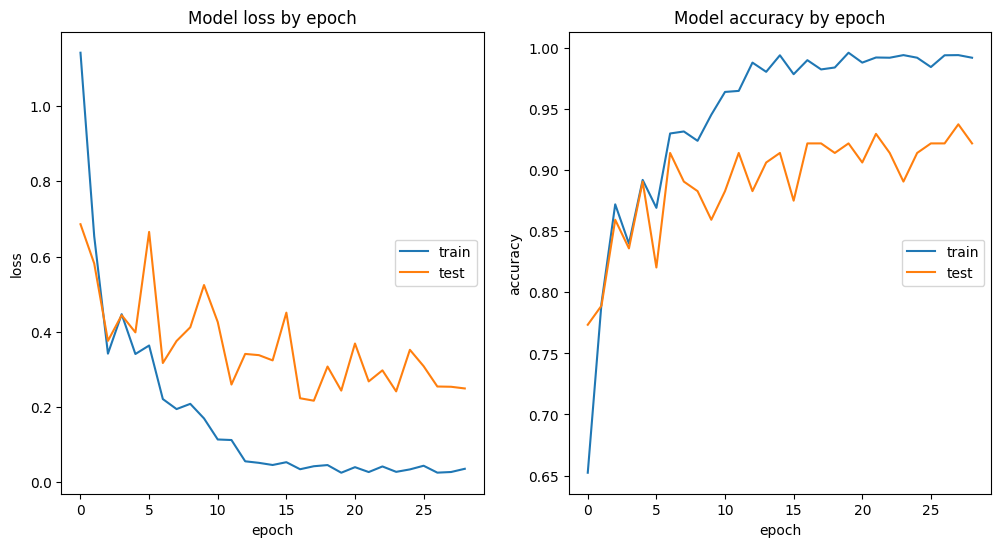

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> E. CONFUSION MATRIX

In [15]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 78ms/step


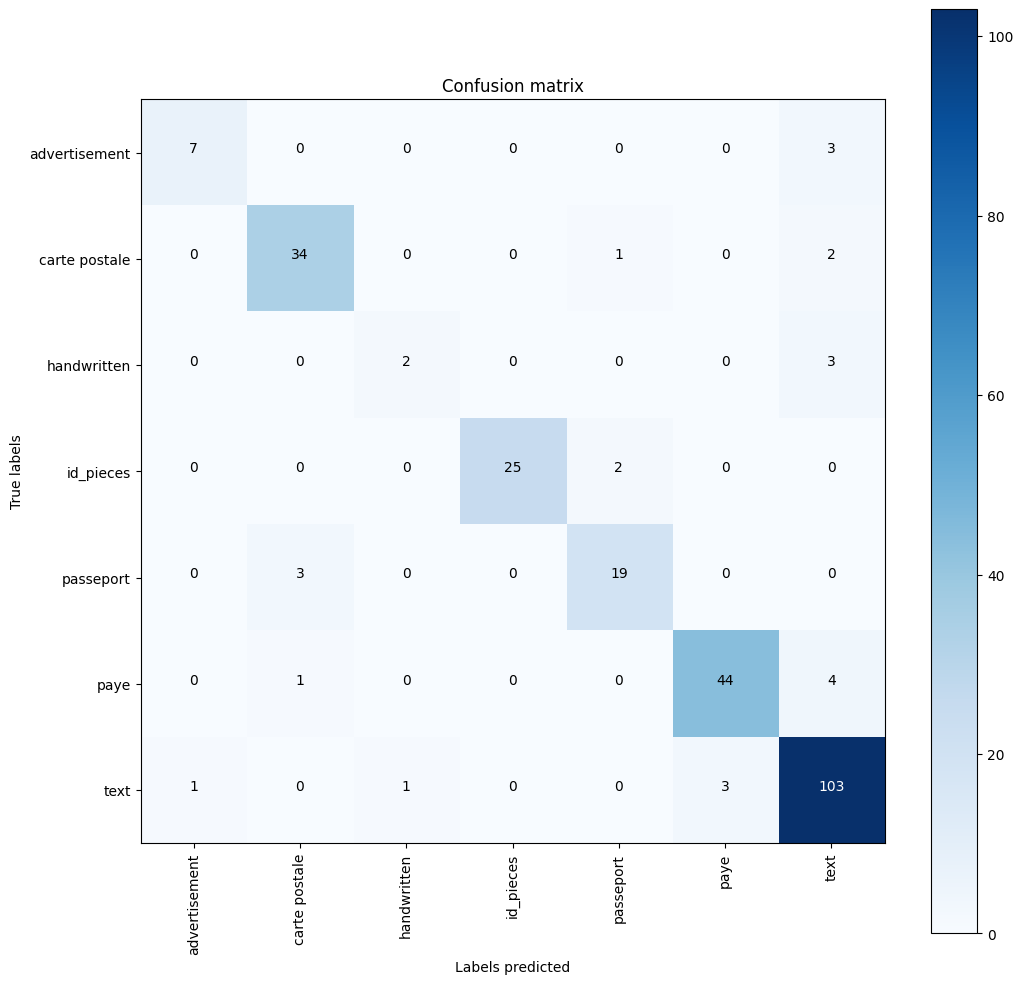

In [16]:
# Dictionaries for target
dico_type = test_generator.class_indices
dico_type_inv = {v: k for k, v in dico_type.items()}

# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

confusion_matrix(y_test, y_pred_type)

> F. CLASSIFICATION REPORT

In [17]:
print( classification_report(y_test, y_pred_type) )

               precision    recall  f1-score   support

advertisement       0.88      0.70      0.78        10
carte postale       0.89      0.92      0.91        37
  handwritten       0.67      0.40      0.50         5
    id_pieces       1.00      0.93      0.96        27
    passeport       0.86      0.86      0.86        22
         paye       0.94      0.90      0.92        49
         text       0.90      0.95      0.92       108

     accuracy                           0.91       258
    macro avg       0.88      0.81      0.84       258
 weighted avg       0.91      0.91      0.90       258



## <font color = blue>IV. FINE TUNING</font>
>A. UNFREEZING WEIGHTS OF TOP LAYERS OF ResNet50<br>

<font color = red>We unfreeze the top 20 layers while leaving BatchNorm layers frozen.</font>

In [18]:
for layer in resnet.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

> B. COMPILING AND TRAINING

In [19]:
last_learning_rate = model.optimizer.learning_rate.numpy()              # collect last learning rate from previous training

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),                            # loss function
              optimizer = tf.keras.optimizers.Adam(learning_rate = last_learning_rate),    # optimizer algorithm
              metrics = ['accuracy'])                                                      # metric

In [20]:
# Callback lr_plateau patience decreased from 4 to 3
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',                # Metric to control
                                         patience = 3,                        # Number of epochs to wait before decreasing the learning rate
                                         factor = 0.1,
                                         verbose = 2,                         # Number of informations displayed during training
                                         mode = 'min')                        # Indicate the metric decrease

In [21]:
# Callback early_stopping patience decreased from 12 to 9
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',          # Metric to control
                                         patience = 9,                  # Number of epochs to wait before stopping the training
                                         mode = 'min',                  # Indicate the metric decrease
                                         restore_best_weights = True)   # To restore the weights of the best epoch

In [22]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                           # Training data
                    validation_data = test_generator,                              # Validation data
                    epochs = 50,                                                   # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // (BATCH_SIZE * 2),     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // (BATCH_SIZE * 2),     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                      # Callbacks
                    workers = -1)                                                  # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 9s 289ms/step - loss: 0.0460 - accuracy: 0.9883 - val_loss: 0.2460 - val_accuracy: 0.9297 - lr: 1.0000e-07
Epoch 2/50
32/32 [==============================] - 8s 266ms/step - loss: 0.0315 - accuracy: 0.9920 - val_loss: 0.3454 - val_accuracy: 0.9062 - lr: 1.0000e-07
Epoch 3/50
32/32 [==============================] - 8s 264ms/step - loss: 0.0497 - accuracy: 0.9863 - val_loss: 0.3766 - val_accuracy: 0.8906 - lr: 1.0000e-07
Epoch 4/50
32/32 [==============================] - 9s 276ms/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.2412 - val_accuracy: 0.9375 - lr: 1.0000e-07
Epoch 5/50
32/32 [==============================] - 9s 274ms/step - loss: 0.0339 - accuracy: 0.9922 - val_loss: 0.2498 - val_accuracy: 0.9141 - lr: 1.0000e-07
Epoch 6/50
32/32 [==============================] - 9s 267ms/step - loss: 0.0423 - accuracy: 0.9900 - val_loss: 0.2264 - val_accuracy: 0.9062 - lr: 1.0000e-07
Epoch 7/50
32/32 [==============================] - 9s 27

In [23]:
####### SAVING WEIGHTS #######
model.save_weights(SAVED_WEIGHTS)

> C. TRAINING HISTORY

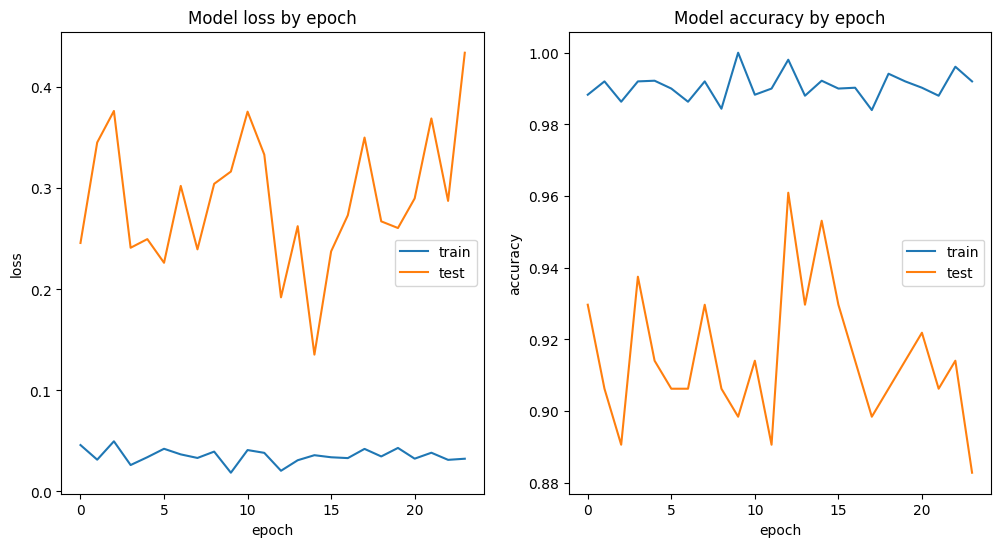

In [24]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX

In [25]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


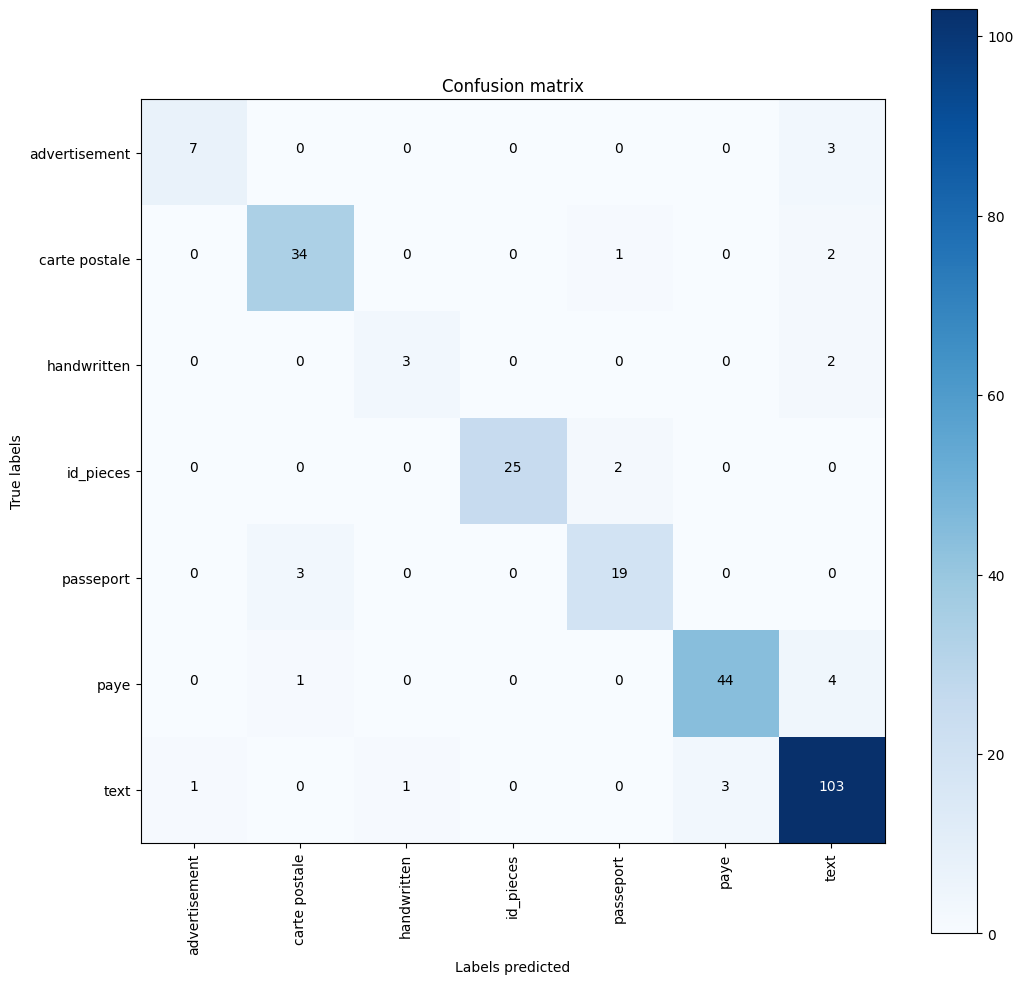

In [26]:
# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

confusion_matrix(y_test, y_pred_type)

> E. CLASSIFICATION REPORT

In [27]:
global_classification_report(y_test, y_pred_type, classifier = "ResNet50 AugmentedData", category = "ComputerVision target_limited_corr")

               precision    recall  f1-score   support

advertisement       0.88      0.70      0.78        10
carte postale       0.89      0.92      0.91        37
  handwritten       0.75      0.60      0.67         5
    id_pieces       1.00      0.93      0.96        27
    passeport       0.86      0.86      0.86        22
         paye       0.94      0.90      0.92        49
         text       0.90      0.95      0.93       108

     accuracy                           0.91       258
    macro avg       0.89      0.84      0.86       258
 weighted avg       0.91      0.91      0.91       258



## <font color = blue>V. WRONG PREDICTIONS</font>

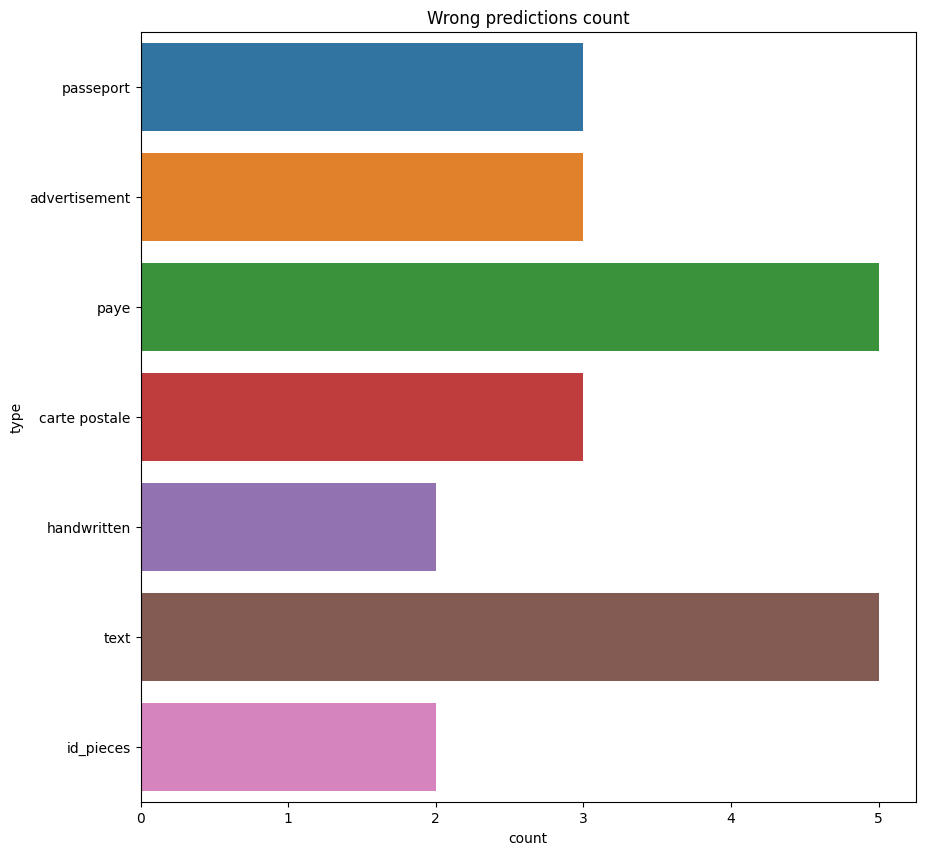

## Wrong predictions for paye

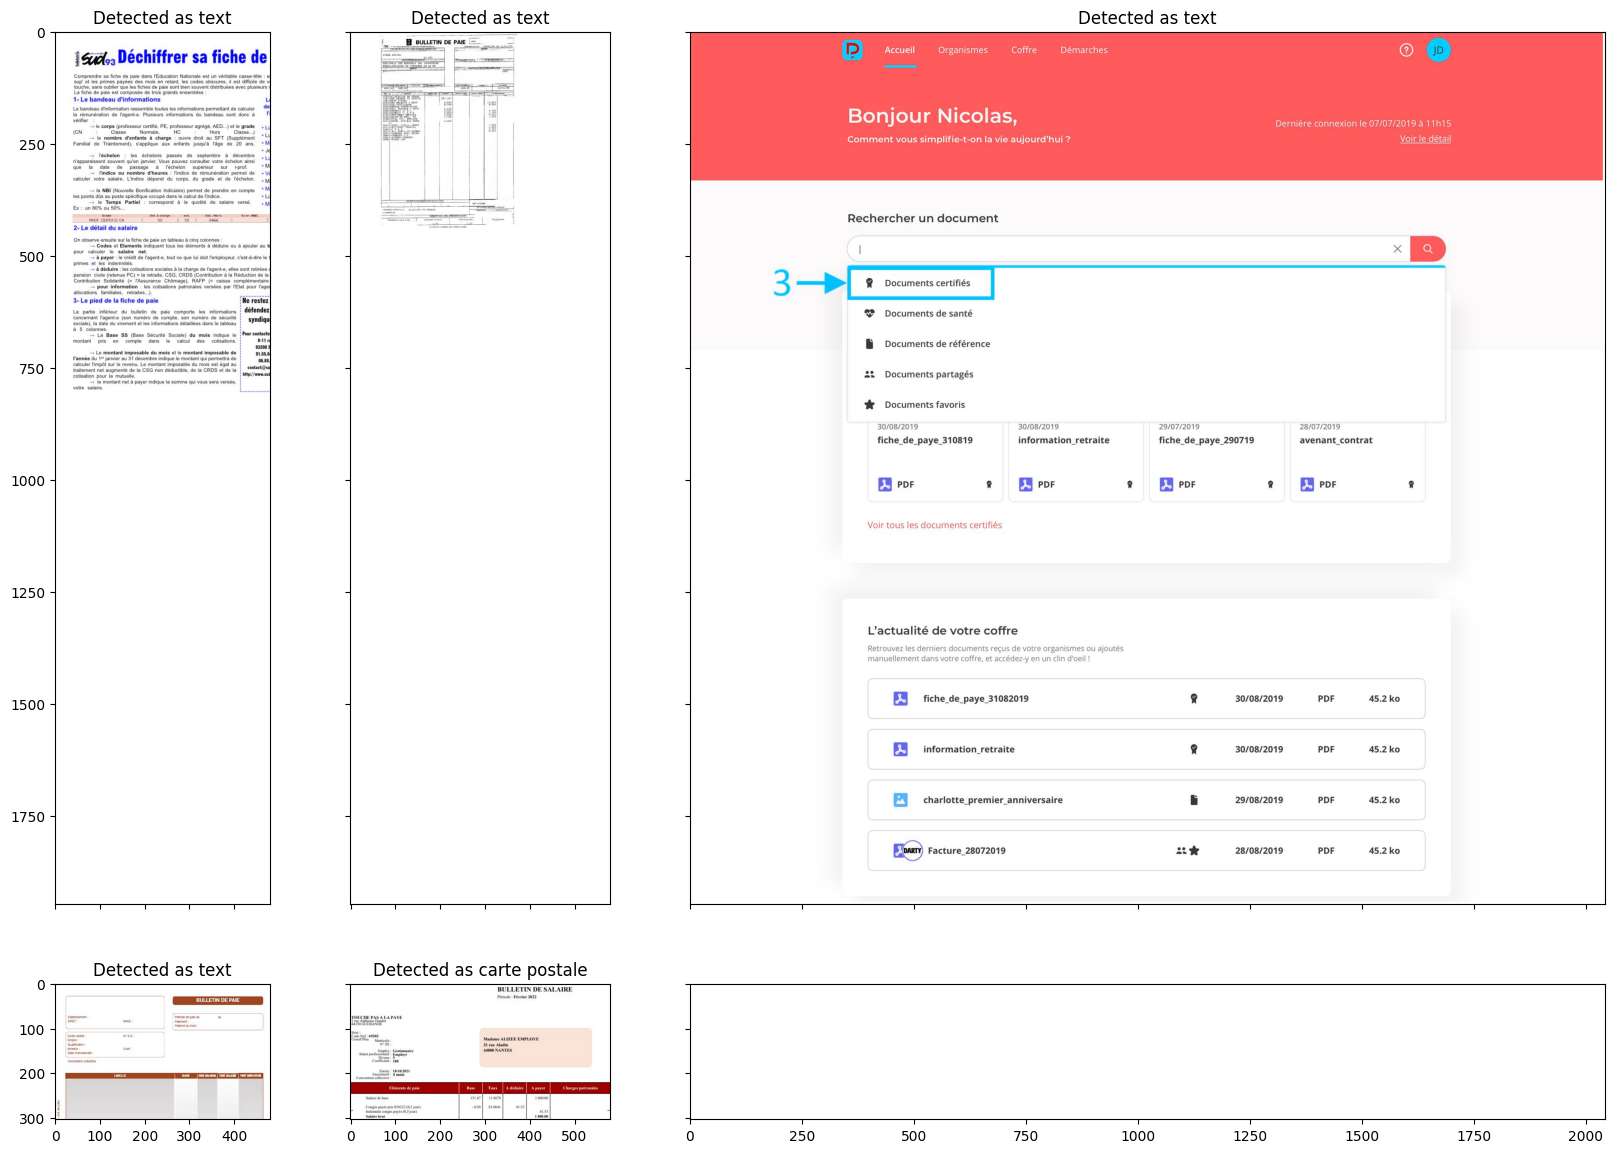

## Wrong predictions for text

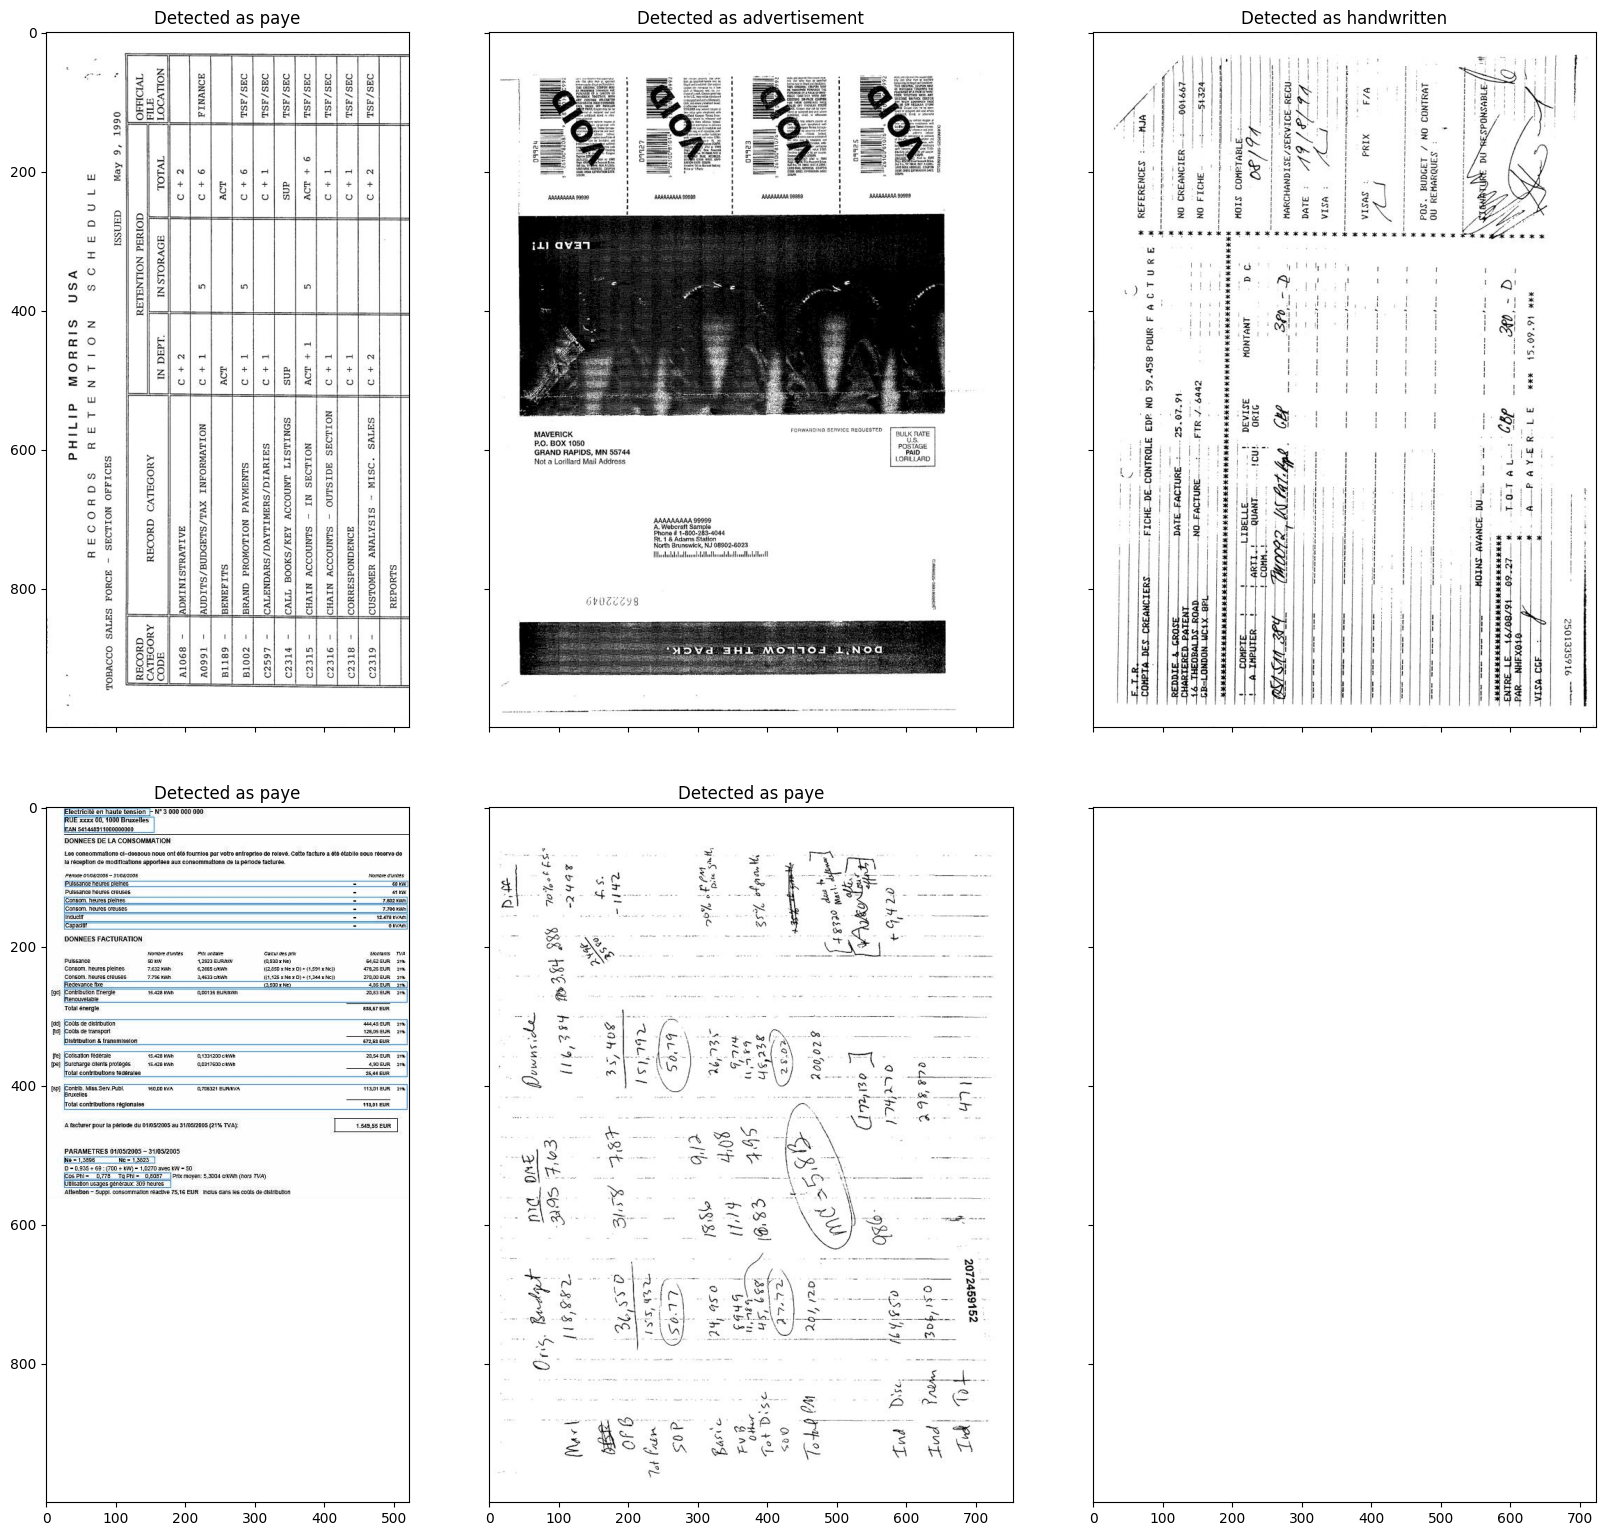

## Wrong predictions for passeport

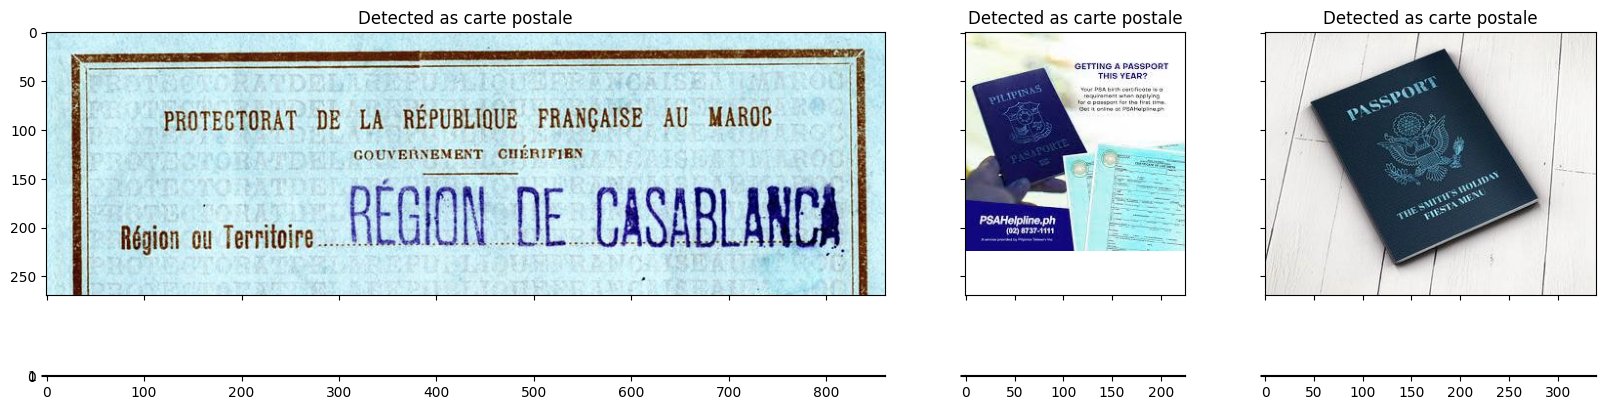

## Wrong predictions for advertisement

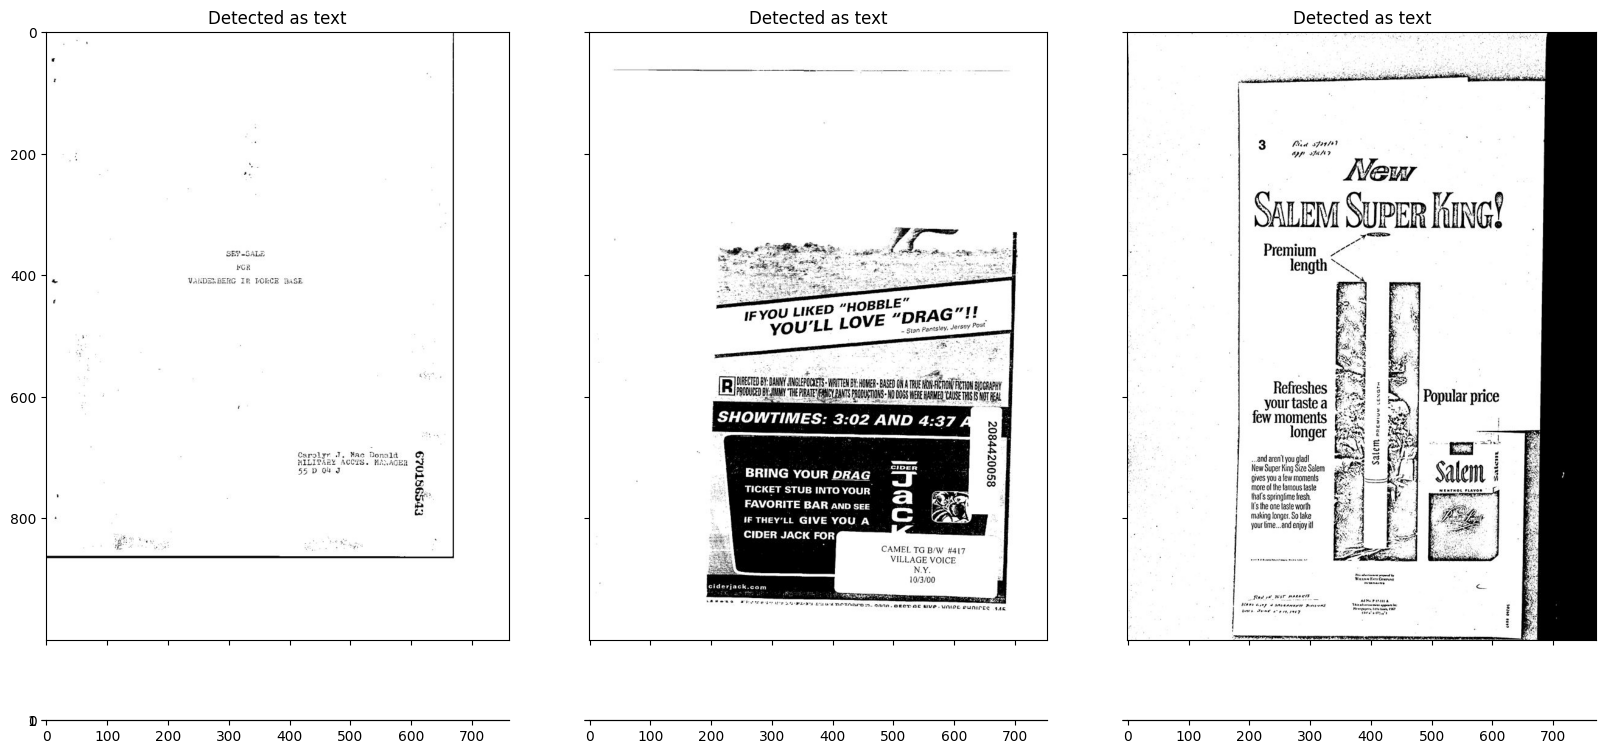

## Wrong predictions for carte postale

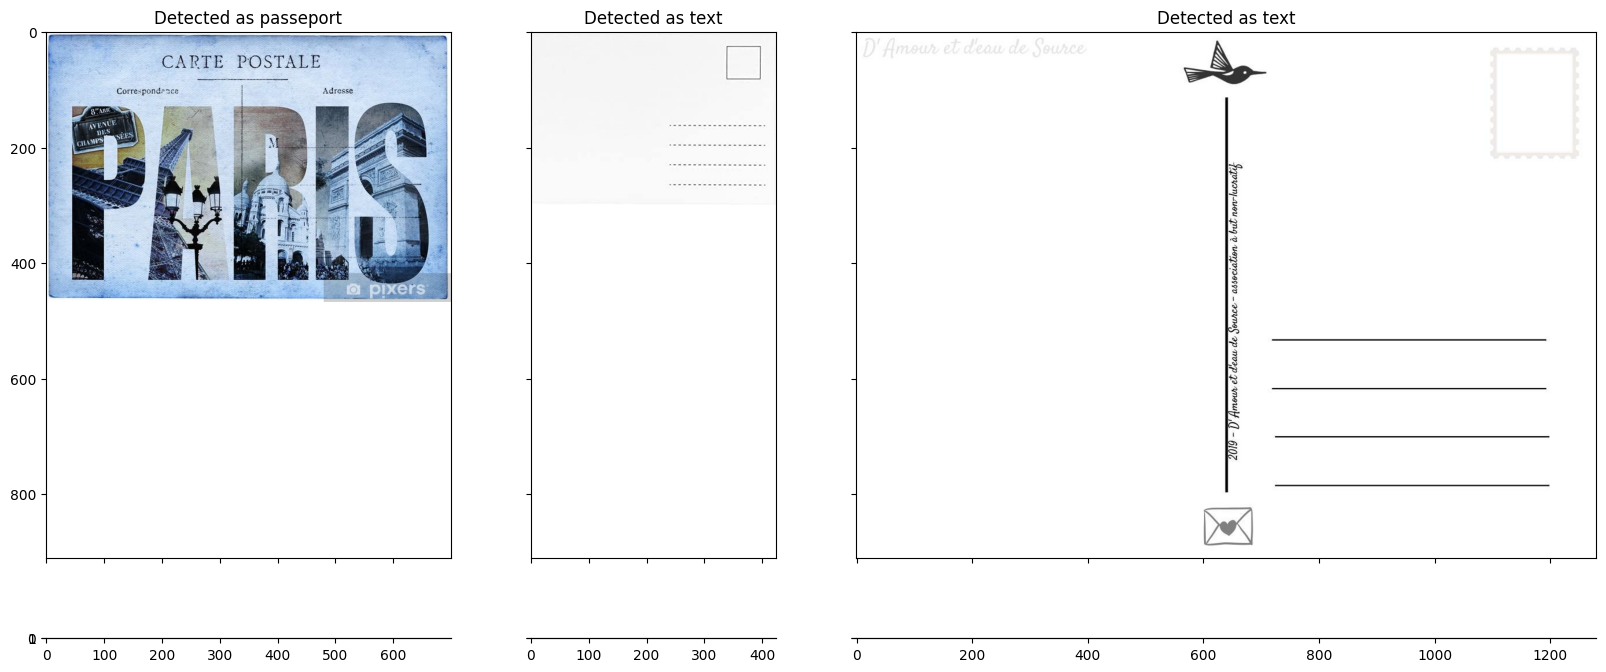

## Wrong predictions for handwritten

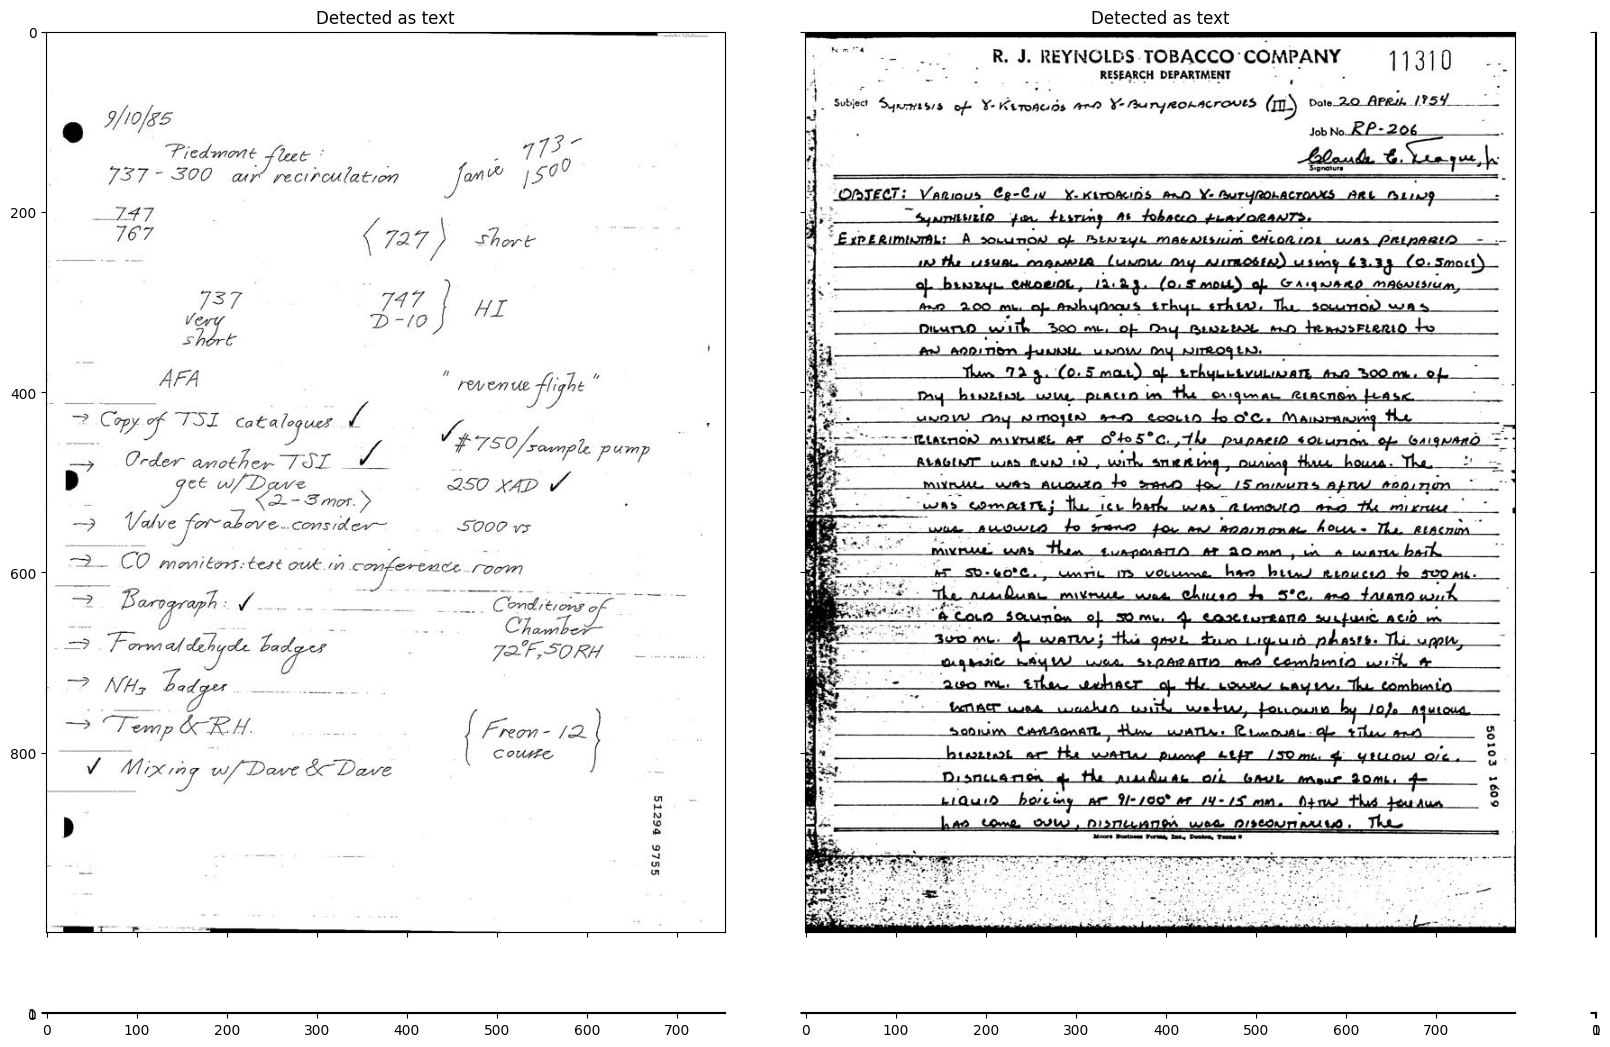

## Wrong predictions for id_pieces

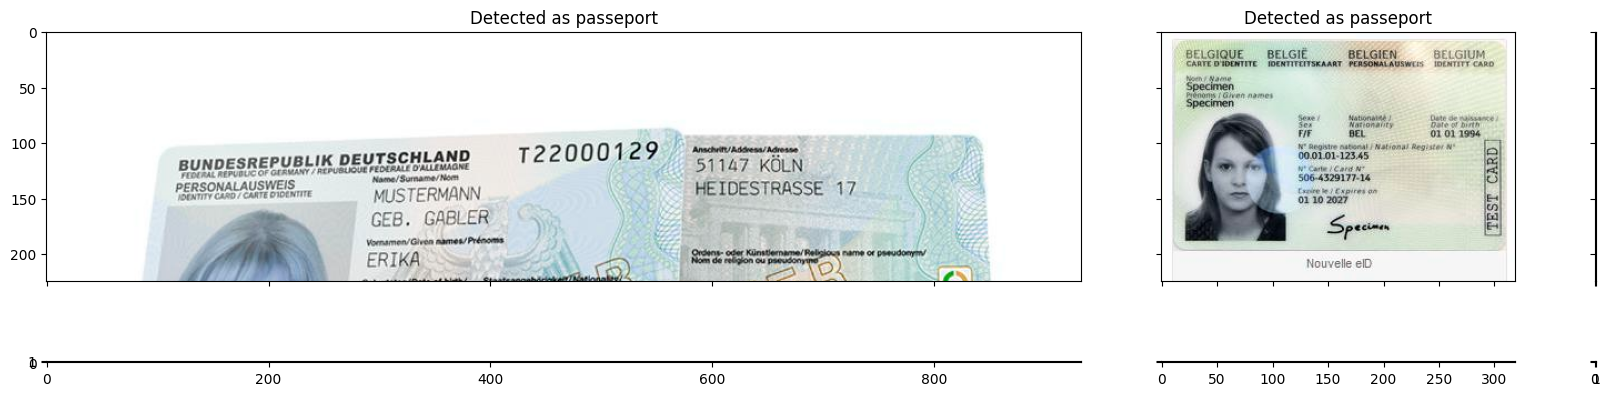

In [28]:
show_wrong_predictions(df, y_test, y_pred_type)

## <font color = blue>VI. SAVING PREDICTIONS</font>

In [29]:
df_test['prediction'] = y_pred_type

In [30]:
df_test.head()

filename           type     prediction
328  img_0000349.jpg      passeport      passeport
797  img_0001119.jpg  advertisement  advertisement
971  img_0001293.jpg           text           text
266  img_0000286.jpg      passeport  carte postale
642  img_0000664.jpg  carte postale  carte postale

In [31]:
df_test.to_csv('../data/CV-predictions-corr.csv', index = False)